In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from gapfill_NN import gapfill_NN
import matplotlib.dates as mdates
%matplotlib inline

Read the data and add time variables

In [44]:
def add_time_vars(data):
    """Adds time variables to data

    Args:
        data (pd.DataFrame): Data

    Returns:
        pd.DataFrame: Data with added time variables (DOY and cyclical tranformations of time of day and season)

    """
    data["row_nr"] = np.arange(len(data))
    data["Month"] = data.index.month
    data["Hour"] = data.index.hour + data.index.minute / 60
    for year in data.index.year.unique():
        lencur = len(data[data.index.year == year])
        lenyear = 365 * 48
        if (
            data[data.index.year == year].index[0].month
            == 1 & data[data.index.year == year].index[0].day
            == 1
        ):
            xnorm = 2 * np.pi * np.arange(0, lencur) / lenyear
        else:
            xnorm = 2 * np.pi * np.arange(lenyear - lencur, lenyear) / lenyear
        data.loc[data.index.year == year, "Month_sin"] = np.sin(xnorm)
        data.loc[data.index.year == year, "Month_cos"] = np.cos(xnorm)

    data["DOY"] = data.index.dayofyear
    data["Hour_sin"] = np.sin(data.Hour * 2 * (2.0 * np.pi / 48))
    data["Hour_cos"] = np.cos(data.Hour * 2 * (2.0 * np.pi / 48))
    data.drop(columns=["row_nr", "Month", "Hour"])
    return data

data = pd.read_csv('Data/FI-Hyy_2015.csv', index_col=0, parse_dates=True)
data.replace({-9999:np.nan}, inplace=True)
data = add_time_vars(data)

Gap-fill

In [45]:
y_col = 'NEE'
x_cols = ['TA_F', 'SW_IN_F', 'VPD_F', 'DOY', 'Month_sin', 'Month_cos', 'Hour_sin', 'Hour_cos']

learning_rate = 0.0001
bsize = 64
l2_reg = 0.0001
N = 5

gpf = gapfill_NN(data, x_cols, y_col, learning_rate, bsize, l2_reg, N)
gpf.to_csv('FI-Hyy_2015_gapfilled.csv')

Epoch 258: early stopping
548/548 [==============================] - 1s 925us/step
Epoch 227: early stopping
548/548 [==============================] - 1s 954us/step
Epoch 202: early stopping
548/548 [==============================] - 1s 943us/step
Epoch 250: early stopping
548/548 [==============================] - 1s 1ms/step


Calculate balance and uncertainty

In [38]:
def calc_unc(df):
    epist = df.filter(regex='modelled_NEE\d').sum().mul(1.8).std()*1.96
    aleat = np.sqrt((df[df.NEE.isnull()].Aleatoric**2).sum()) * 1.8
    total_unc = np.sqrt(epist**2+aleat**2)
    return total_unc

gpf = pd.read_csv('FI-Hyy_2015_gapfilled.csv', index_col=0, parse_dates=True)

co2_balance = gpf.gapfilled_NEE.sum()*1.8
co2_balance_uncertainty = calc_unc(gpf)

print(f'CO2 balance: {round(co2_balance)} (g CO2 m-2)')
print(f"Gapfilling uncertainty: {round(co2_balance_uncertainty)} (g CO2 m-2, 95% CI)")

CO2 balance: -798 (g CO2 m-2)
Gapfilling uncertainty: 203 (g CO2 m-2, 95% CI)


Plot

Text(0, 0.5, 'Cumulative NEE')

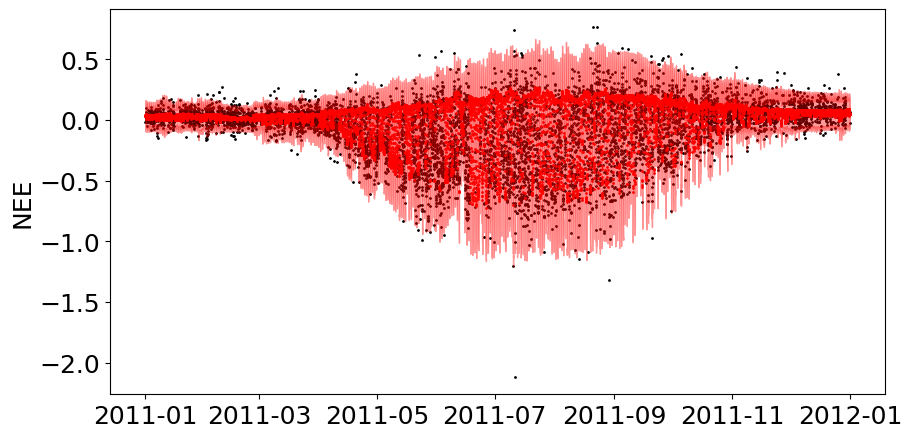

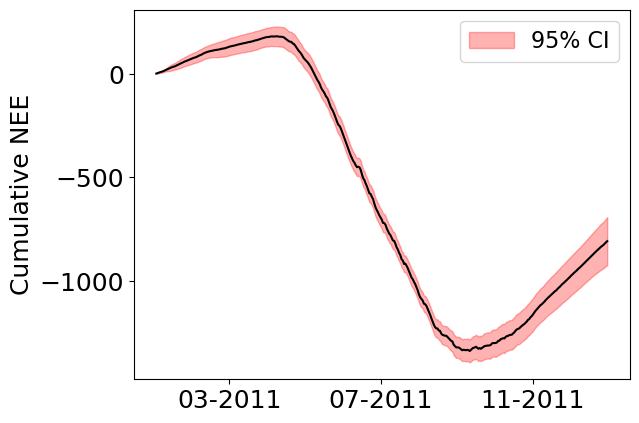

In [42]:
fsize = 18

plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.labelsize"] = fsize
plt.rcParams["ytick.labelsize"] = fsize

fig, ax = plt.subplots(figsize=[10,5])
ax.scatter(gpf.index, gpf.NEE, c='k', s=1)
ax.scatter(gpf[gpf.NEE.isnull()].index, gpf[gpf.NEE.isnull()].modelled_NEE, c='r', s=1)
ax.fill_between(gpf.index, gpf.modelled_NEE+gpf.Emod, gpf.modelled_NEE-gpf.Emod, color='r', alpha=.4)
plt.ylabel("NEE [mg CO$_2$ m$^{-2}$ s$^{-1}$]", fontsize=18)

cumul_sum = gpf.gapfilled_NEE.resample('D').sum().cumsum()*1.8
cumul_unc = [calc_unc(gpf[:date]) for date in np.unique(gpf.index.date)]

fig, ax = plt.subplots()
ax.plot(cumul_sum.index, cumul_sum, c='k')
ax.fill_between(cumul_sum.index, cumul_sum+cumul_unc, cumul_sum-cumul_unc, color='r', alpha=.3, label="95% CI")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))
ax.legend(loc='best', prop={'size':fsize-2})
ax.set_ylabel("Cumulative NEE [g CO$_2$ m$^{-2}$]", fontsize=fsize)